# INTEGRATED GRADIENTS Values Analysis

t computes the gradient of the model’s output with respect to the input features, integrated over a straight-line path from a baseline (e.g. all zeroes) to the actual input. Integrated Gradients provide attribution scores that highlight the relative importance of each feature in driving the prediction.

In this notebook, we analyze IG values generated for our drug synergy prediction models (Biomining, TranSynergy) using a mean baseline for Biomining and a shuffled baseline for Transynergy.

The biological analysis will focus on 2 cell lines for each model, shown at the end of each section (Biomining and Transynergy)

## Biomining

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist
import pandas as pd

In [2]:
import sys
from pathlib import Path
import os 

project_root = Path.cwd().parents[1]  
sys.path.append(str(project_root))
os.chdir(project_root)

In [3]:
from explainability.explaination_config import ExplainationConfig
config = ExplainationConfig("biomining")
feature_name = config.feature_names
print(feature_name)

['ABL1', 'ABL1b', 'CSF1R', 'CSF1Rb', 'EGFR', 'EGFRb', 'FLT1', 'FLT1b', 'FLT4', 'FLT4b', 'KDR', 'KDRb', 'KIT', 'KITb', 'MCL1', 'MCL1b', 'NR1I2', 'NR1I2b', 'PDGFRB', 'PDGFRBb', 'RET', 'RETb', 'TOP2A', 'TOP2Ab', 'TUBB1', 'TUBB1b', 'GATA3', 'NF1', 'NF2', 'P53', 'PI3K', 'PTEN', 'RAS']


In [4]:
SAVE_PATH = "explainability/ig/results/biomining_integrated_gradients_mean.pt"
all_attributions = torch.load(SAVE_PATH, weights_only=False)

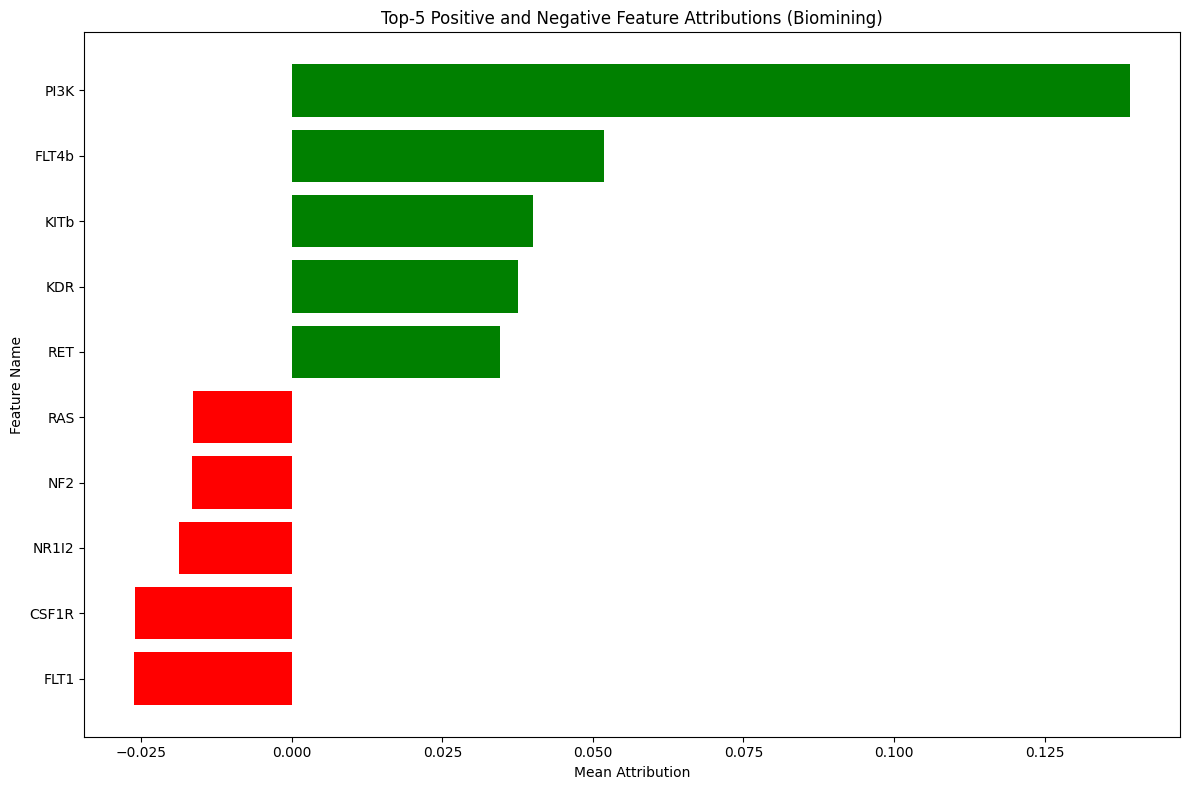

In [5]:
mean_attributions = all_attributions.mean(dim=0).squeeze().numpy()  
indices = np.argsort(mean_attributions)
top_negative = indices[:5]  
top_positive = indices[-5:]  
top_indices = np.concatenate([top_negative, top_positive])
feature_values = mean_attributions[top_indices]
feature_labels = [feature_name[i] for i in top_indices]
plt.figure(figsize=(12, 8))
plt.barh(feature_labels, feature_values, color=np.where(np.array(feature_values) < 0, 'red', 'green'))
plt.title("Top-5 Positive and Negative Feature Attributions (Biomining)")
plt.xlabel("Mean Attribution")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()
plt.close()

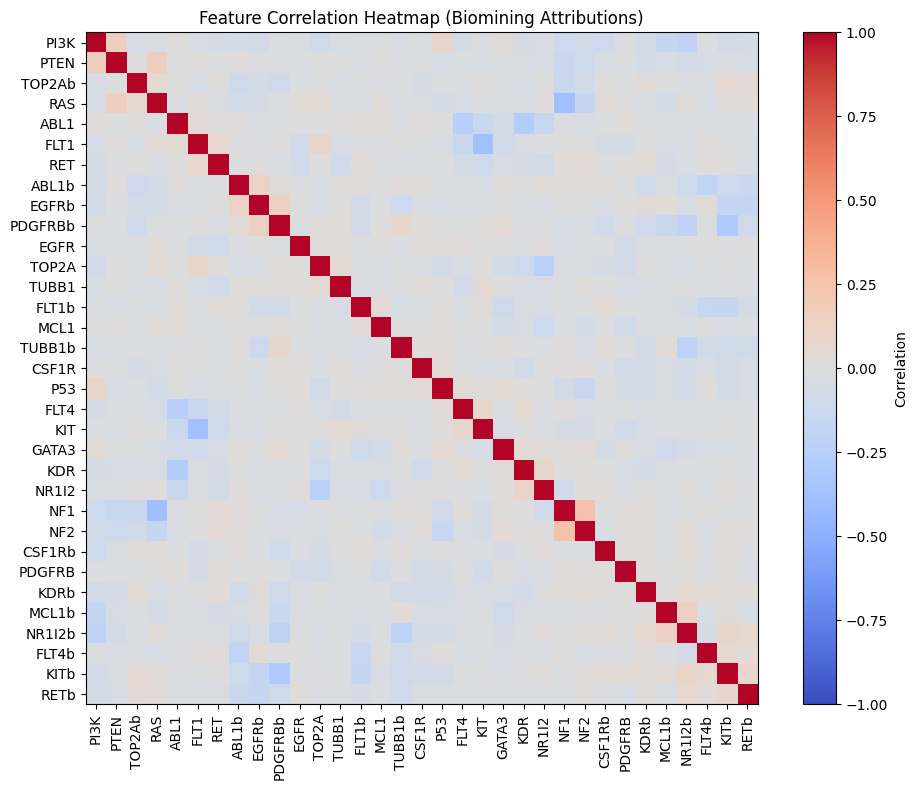

In [6]:
attributions_np = all_attributions.squeeze().numpy()  

variances = np.var(attributions_np, axis=0)
valid_indices = np.where(variances > 0)[0]
attributions_np_filtered = attributions_np[:, valid_indices]
feature_cols_filtered = [feature_name[i] for i in valid_indices]

correlation_matrix = np.corrcoef(attributions_np_filtered, rowvar=False) 
linkage_matrix = linkage(pdist(correlation_matrix), method='average')
order = leaves_list(linkage_matrix)
reordered_matrix = correlation_matrix[np.ix_(order, order)]
reordered_labels = [feature_cols_filtered[i] for i in order]
plt.figure(figsize=(10, 8))
plt.imshow(reordered_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.xticks(range(len(reordered_labels)), reordered_labels, rotation=90)
plt.yticks(range(len(reordered_labels)), reordered_labels)
plt.title("Feature Correlation Heatmap (Biomining Attributions)")
plt.tight_layout()
plt.show()


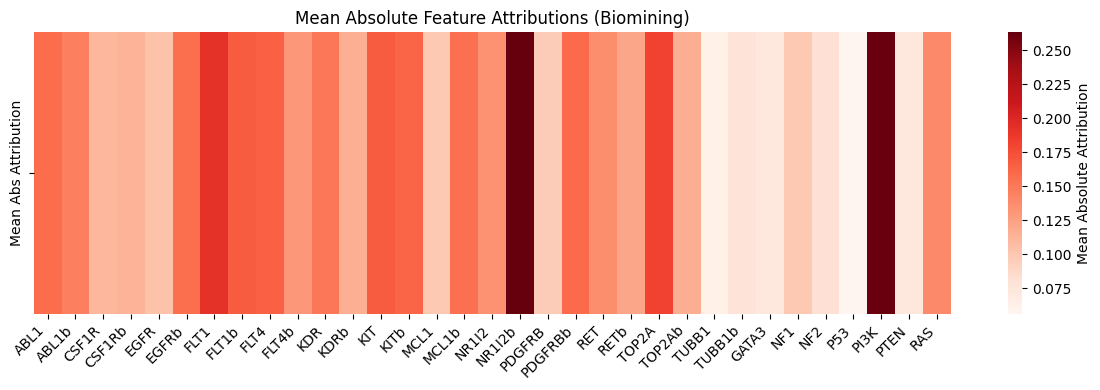

In [7]:
mean_abs_attributions = np.abs(all_attributions.squeeze().numpy()).mean(axis=0)  # Shape: [33]

plt.figure(figsize=(12, 4))
sns.heatmap(
    mean_abs_attributions.reshape(1, -1),
    cmap='Reds',
    xticklabels=feature_name,
    yticklabels=['Mean Abs Attribution'],
    cbar_kws={'label': 'Mean Absolute Attribution'},
)
plt.title("Mean Absolute Feature Attributions (Biomining)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.close()


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


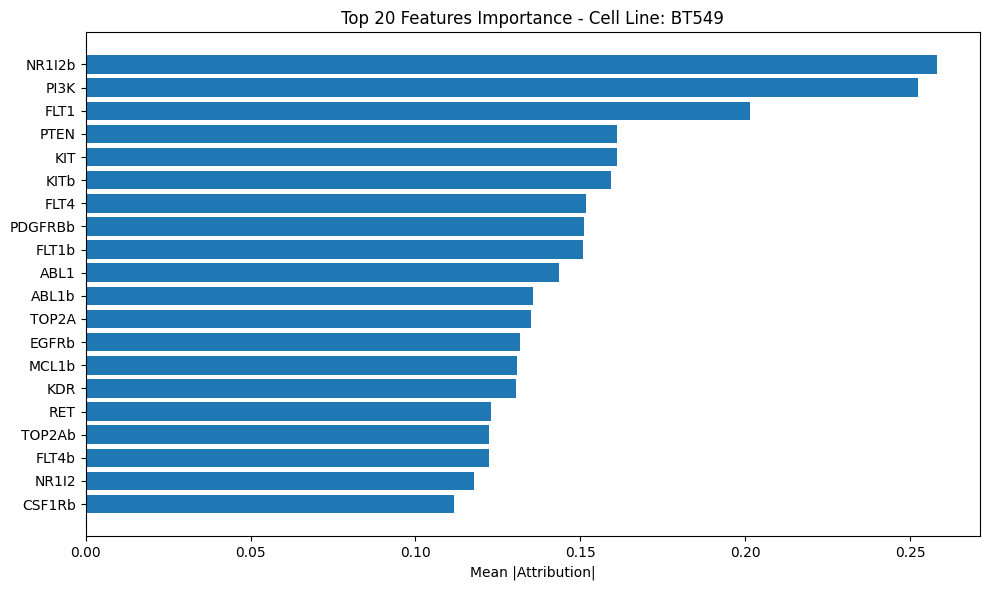

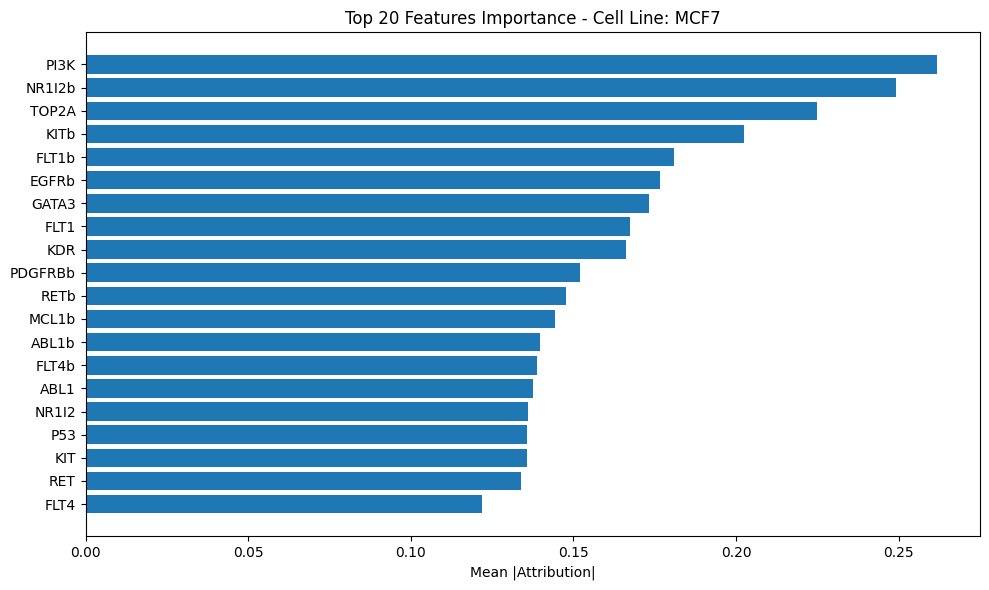

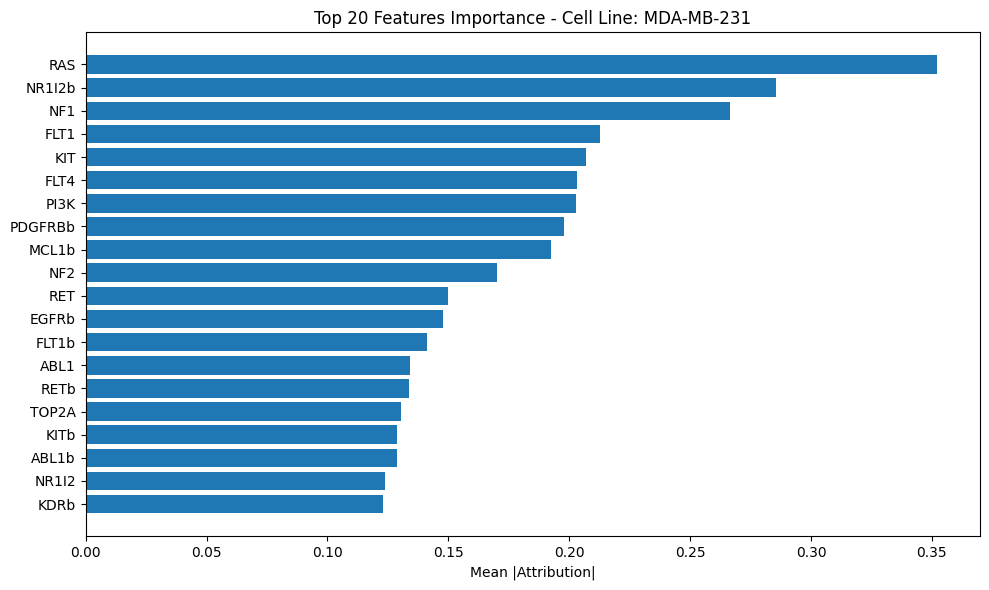

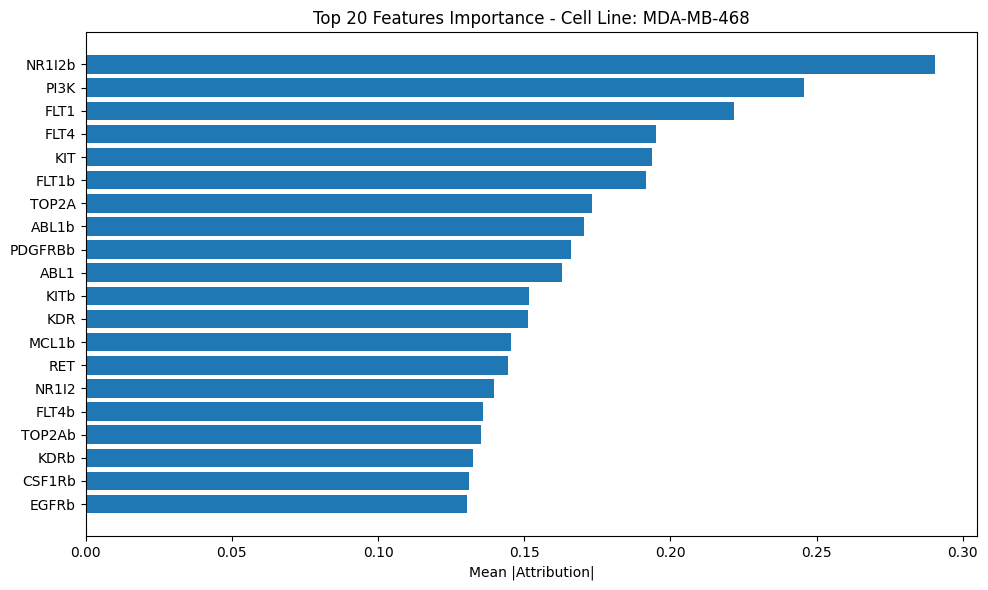

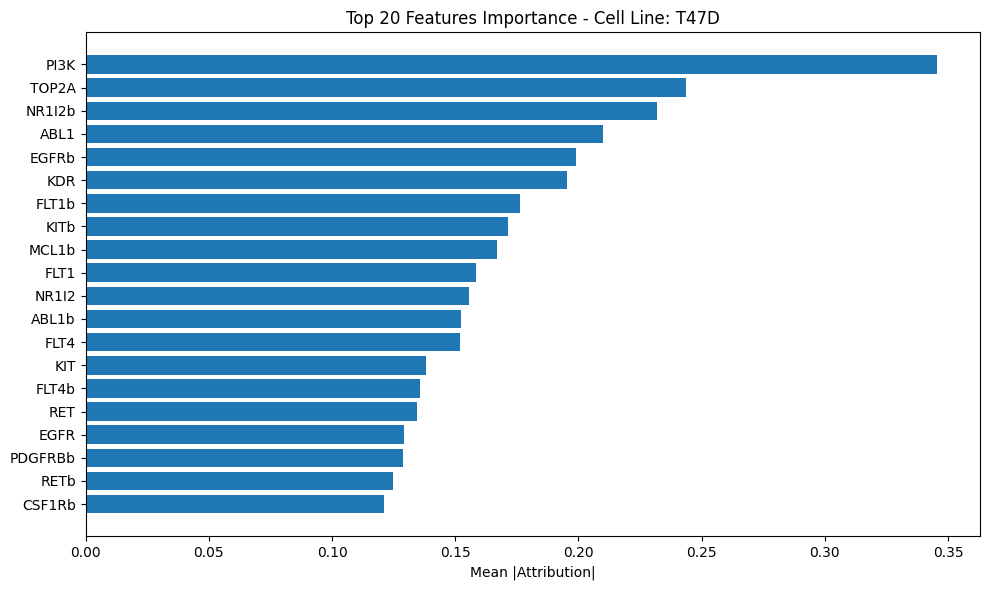

In [9]:
from explainability.data_utils import load_biomining_cell_line_data

def plot_feature_importance_by_cell_line(all_attributions, feature_names, top_n=20):
    cell_lines = load_biomining_cell_line_data(split='train')
    unique_cell_lines = np.unique(cell_lines)

    for cell_line in unique_cell_lines:
        cell_line_indices = np.where(cell_lines == cell_line)[0]
        cell_line_attributions = all_attributions[cell_line_indices]
        
        mean_abs_attributions = np.mean(np.abs(cell_line_attributions), axis=0)
        
        importance_df = pd.DataFrame({
            "feature": feature_names,
            "mean_abs_attribution": mean_abs_attributions
        }).sort_values(by="mean_abs_attribution", ascending=False).head(top_n)
        
        plt.figure(figsize=(10, 6))
        plt.barh(importance_df["feature"][::-1], importance_df["mean_abs_attribution"][::-1])
        plt.xlabel("Mean |Attribution|")
        plt.title(f"Top {top_n} Features Importance - Cell Line: {cell_line}")
        plt.tight_layout()
        plt.show()


# Convert the attributions to a NumPy array for easier manipulation
all_attributions_np = all_attributions.squeeze().numpy()

plot_feature_importance_by_cell_line(all_attributions_np, feature_name)



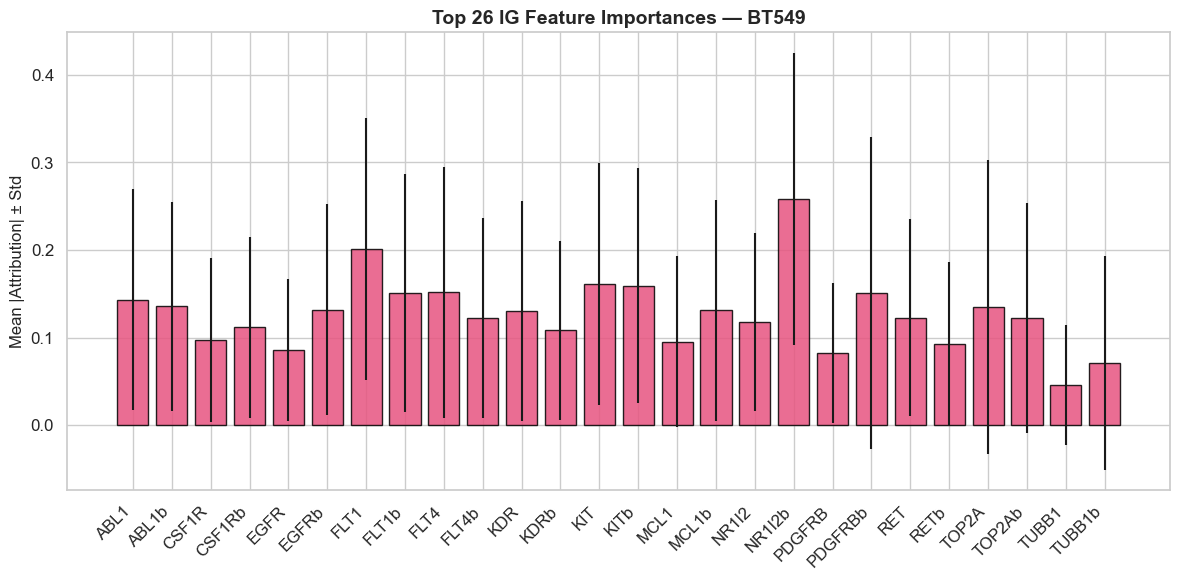

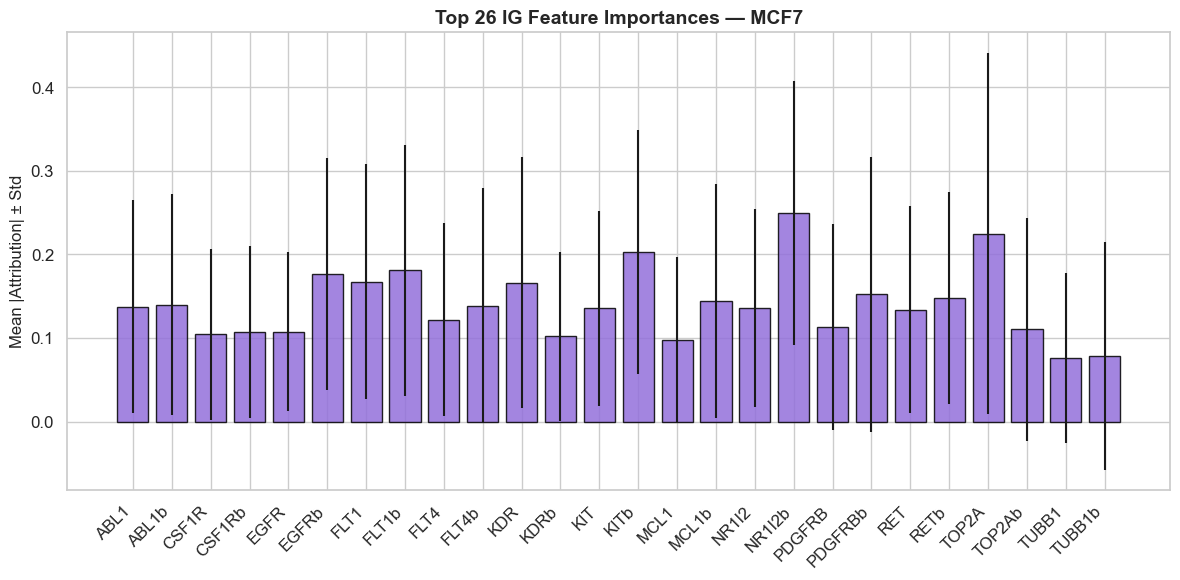

In [10]:
from explainability.data_utils import load_biomining_cell_line_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_ig_feature_importance_by_cell_line(all_attributions, feature_names, top_n=26):
    sns.set(style="whitegrid", font_scale=1.1)
    
    cell_lines = load_biomining_cell_line_data(split='train')
    
    target_cell_lines = sorted(["MCF7", "BT549"])
    color_map = {
        "MCF7": "#9370DB",  
        "BT549": "#e75480"  
    }
    
    mask = np.isin(cell_lines, target_cell_lines)
    filtered_attributions = all_attributions[mask]
    filtered_cell_lines = cell_lines[mask]
    
    trimmed_features = feature_names[:-7]
    filtered_attributions = filtered_attributions[:, :-7]
    
    for cell_line in target_cell_lines:
        indices = np.where(filtered_cell_lines == cell_line)[0]
        attr_subset = filtered_attributions[indices]
        
        mean_abs_attr = np.mean(np.abs(attr_subset), axis=0)
        std_abs_attr = np.std(np.abs(attr_subset), axis=0)
        
        top_indices = np.argsort(mean_abs_attr)[-top_n:]
        top_features = np.array(trimmed_features)[top_indices]
        top_means = mean_abs_attr[top_indices]
        top_stds = std_abs_attr[top_indices]
        
        sorted_order = np.argsort(top_features)
        top_features = top_features[sorted_order]
        top_means = top_means[sorted_order]
        top_stds = top_stds[sorted_order]
        
        plt.figure(figsize=(12, 6))
        plt.bar(top_features, top_means, yerr=top_stds,
                color=color_map[cell_line], edgecolor='black', alpha=0.85)
        plt.ylabel("Mean |Attribution| ± Std", fontsize=12)
        plt.title(f"Top {top_n} IG Feature Importances — {cell_line}", fontsize=14, weight='bold')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

all_attributions_np = all_attributions.squeeze().numpy()
plot_ig_feature_importance_by_cell_line(all_attributions_np, feature_name)


# BT549
- breast cancer cell line, not hormone-dependent, known for its aggressive, invasive behavior for growth and used to study drug resistance
- NR1I2b - Highest Attribution: key regulator of drug metabolism and transportso makes sense
- FLT1 - Second Highest Attribution: controls blood vessel formation, crucial for tumor development
- both of the above mentioned features have very big difference between drug A and B, maybe that shows that only one drug needs to target it, while the other should complement with other stuff
- KIT has similar (relatively high) attribution for A and B: encodes a receptor tyrosine kinase that plays a crucial role in cell signaling, especially for cell growth and survival.
- TUBB1 - Lowest Attribution: it's a beta-tubulin (help maintain cell's shape/ essential cell division), not a major player in many cancer cells, other tubulins are usually more relevant targets in cancer treatment


# MCF-7 
- one of the most widely used breast cancer cell lines and it is hormone-dependent for growth
- NR1I2b: also Highest Attribution (key regulator of drug metabolism and transport), likely relates to hormone metabolism
- TOP2A - Second Highest Attribution: essential for DNA replication and cell division, makes biological sense for hormone-responsive cancer where cell cycle control is crucial
- both of them have very big difference between drug A and B
- here both FLT1 have similar relatively high attributions
- TUBB1 also have the lowest attribution
- CSF1R also low attribution: an immune cell receptor, more relevant in studies involving the tumor microenvironment or immune cells, but less so in pure cancer cell line analyses


## Transynergy

In [8]:
config = ExplainationConfig("transynergy")
feature_name = config.feature_names
print(feature_name)

Index(['GDF5_A', 'NCOA3_A', 'NRIP1_A', 'AMER1_A', 'LZTR1_A', 'ABL1_A',
       'CLTCL1_A', 'ABL2_A', 'ACACB_A', 'ZRSR2_A',
       ...
       'NETO2_CL', 'VANGL1_CL', 'ARID2_CL', 'TCL1A_CL', 'SLC4A10_CL',
       'SLC7A5_CL', 'TAF15_CL', 'ELL_CL', 'OR2A2_CL', 'pIC50_CL'],
      dtype='object', length=7206)


In [9]:
SAVE_PATH = "explainability/ig/results/transynergy_integrated_gradients_shuffled.pt"
all_attributions = torch.load(SAVE_PATH, weights_only=False)

c:\Users\Utilizador\Documents\IST\Erasmus\Classes\SWP Cancer Treatment\Drug-Inhibitor-Cancer-Treatment\venv\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Utilizador\Documents\IST\Erasmus\Classes\SWP Cancer Treatment\Drug-Inhibitor-Cancer-Treatment\venv\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


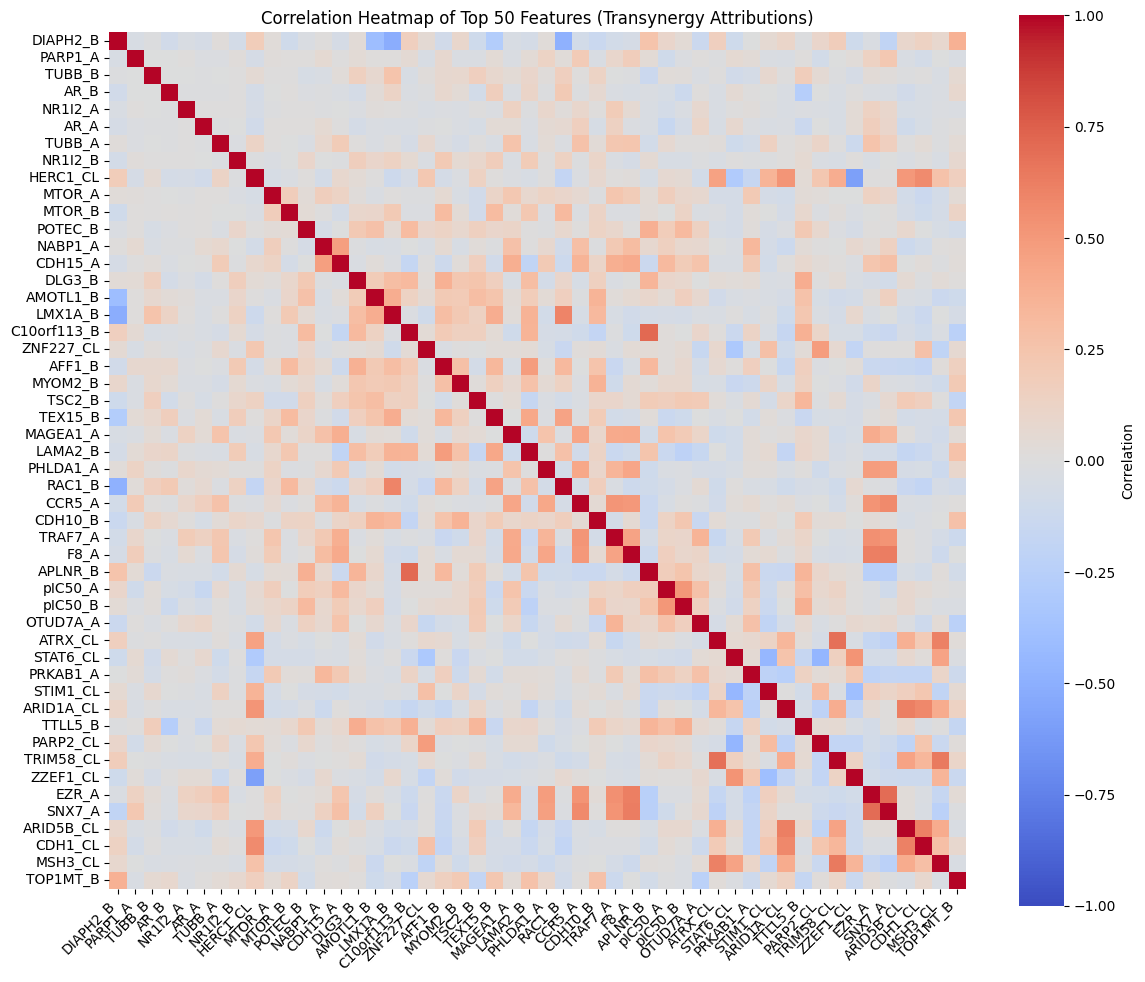

In [10]:
N = all_attributions.shape[0]
attributions_reshaped = all_attributions.squeeze(1).reshape(N, -1)  
attributions_np = attributions_reshaped.numpy()
correlation_matrix = np.corrcoef(attributions_np, rowvar=False)  

mean_attributions = np.abs(attributions_np).mean(axis=0)
top_k_indices = np.argsort(mean_attributions)[-50:]  # Select top 50 features
top_k_features = [feature_name[i] for i in top_k_indices]
correlation_subset = correlation_matrix[top_k_indices][:, top_k_indices]
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_subset,
    xticklabels=top_k_features,
    yticklabels=top_k_features,
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    cbar_kws={'label': 'Correlation'},
)
plt.title("Correlation Heatmap of Top 50 Features (Transynergy Attributions)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()
plt.close()

[fold] Leakage:
  • Test ↔ Train: 0
  • Val  ↔ Train: 0
  • Val  ↔ Test : 0
Original rows: 18552
Remaining rows after cleaning: 18552


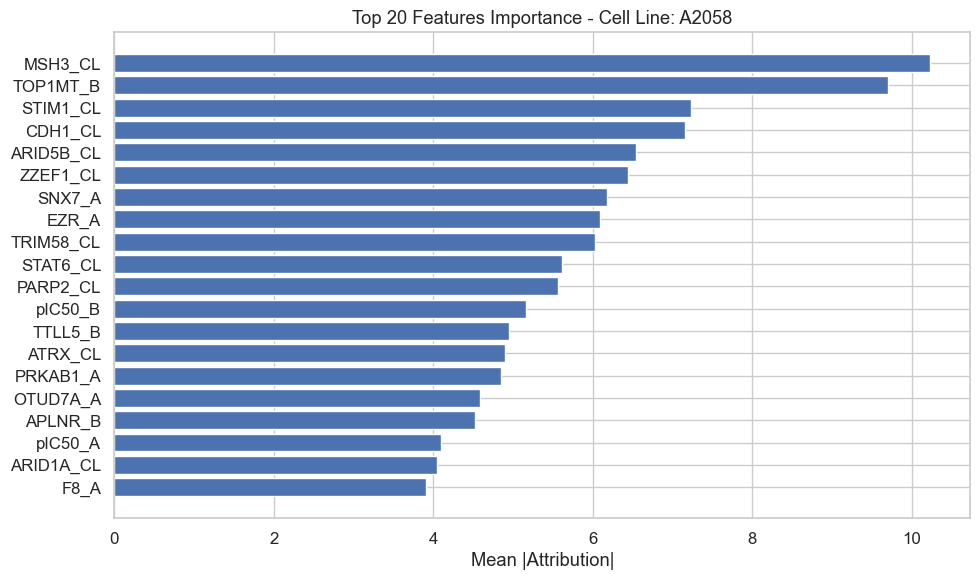

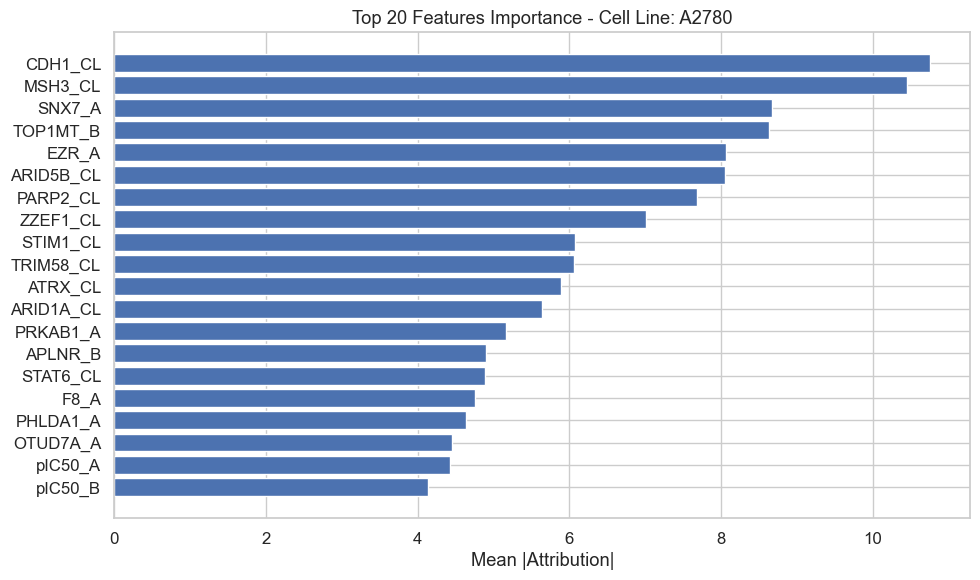

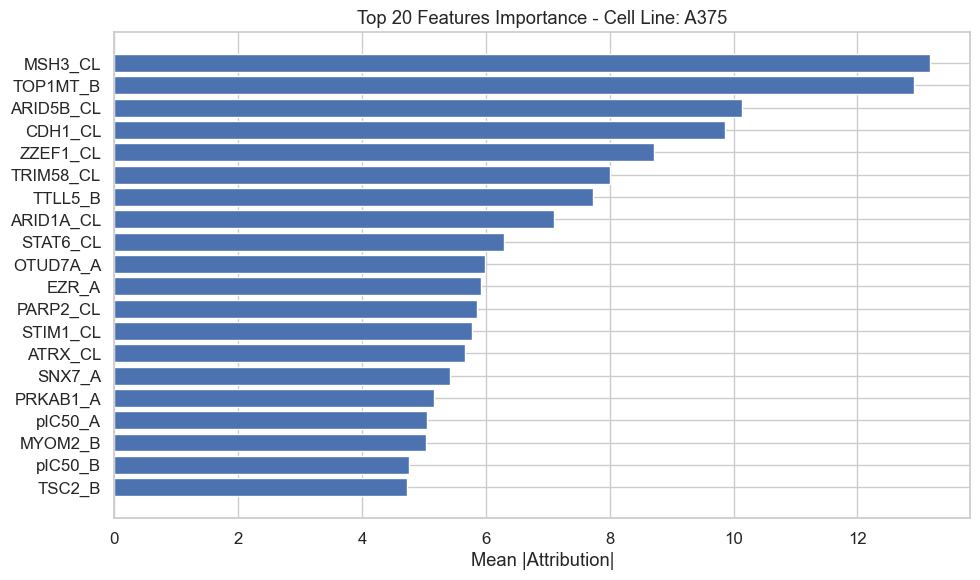

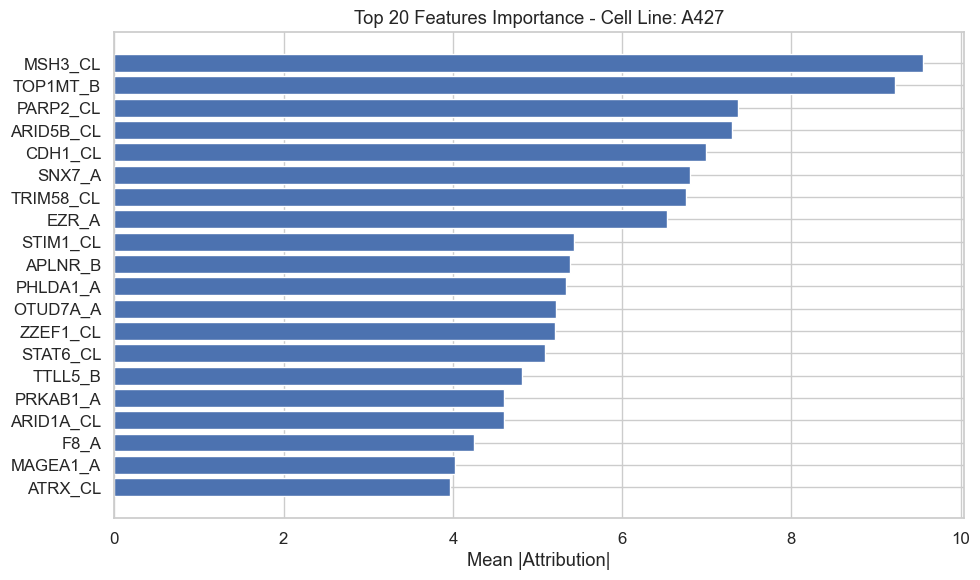

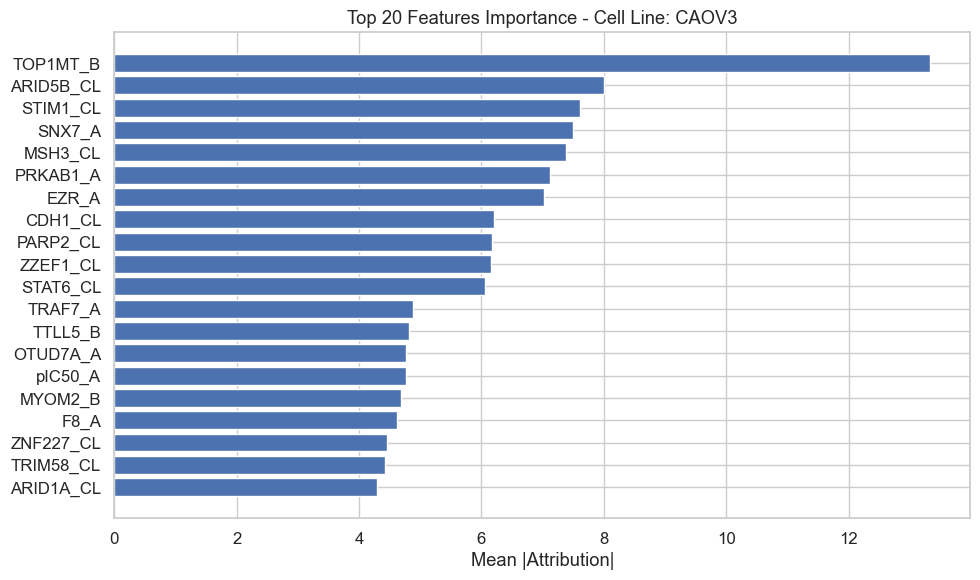

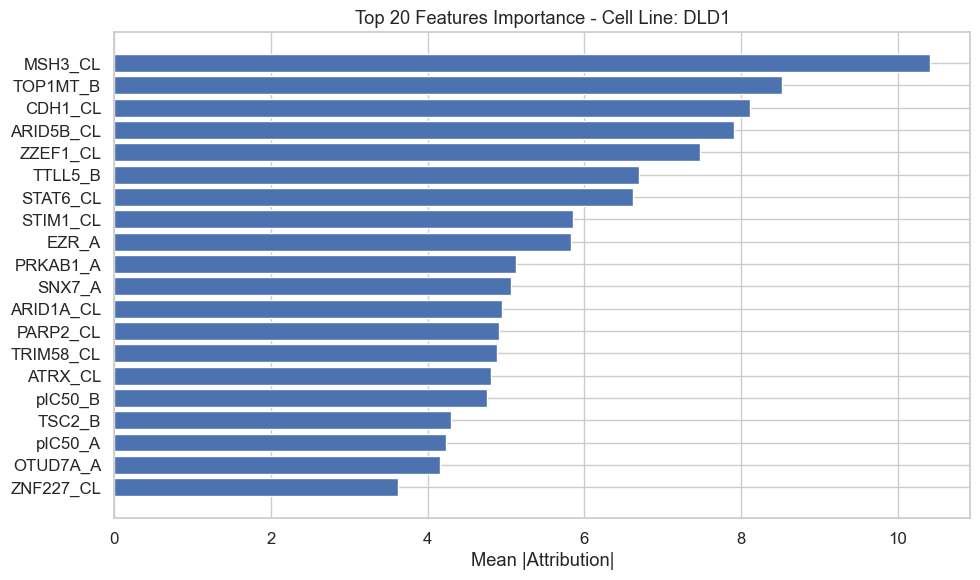

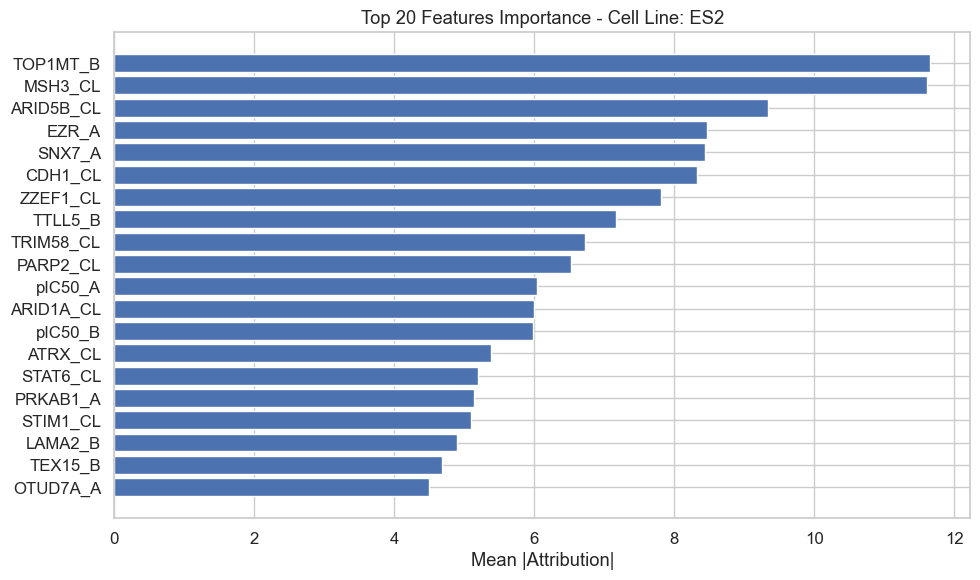

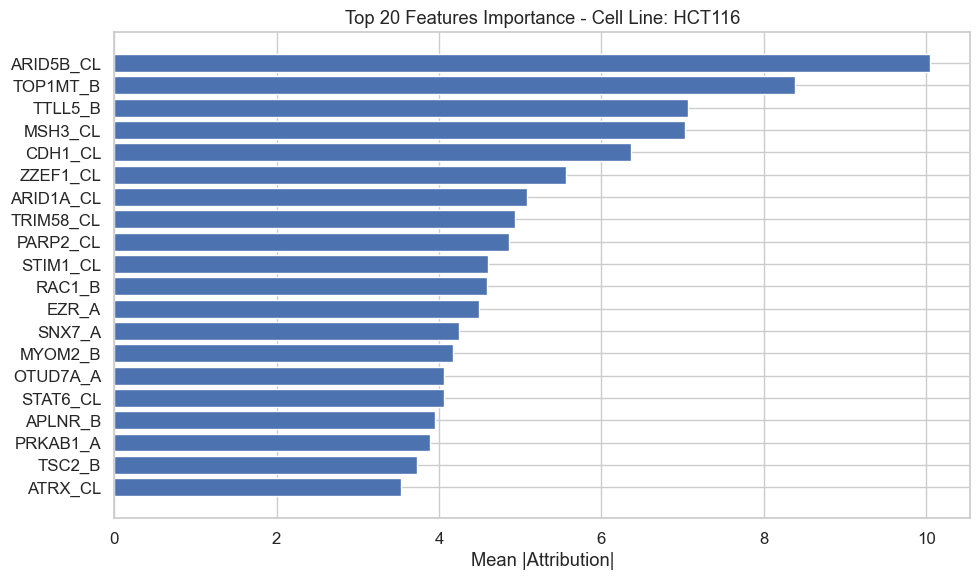

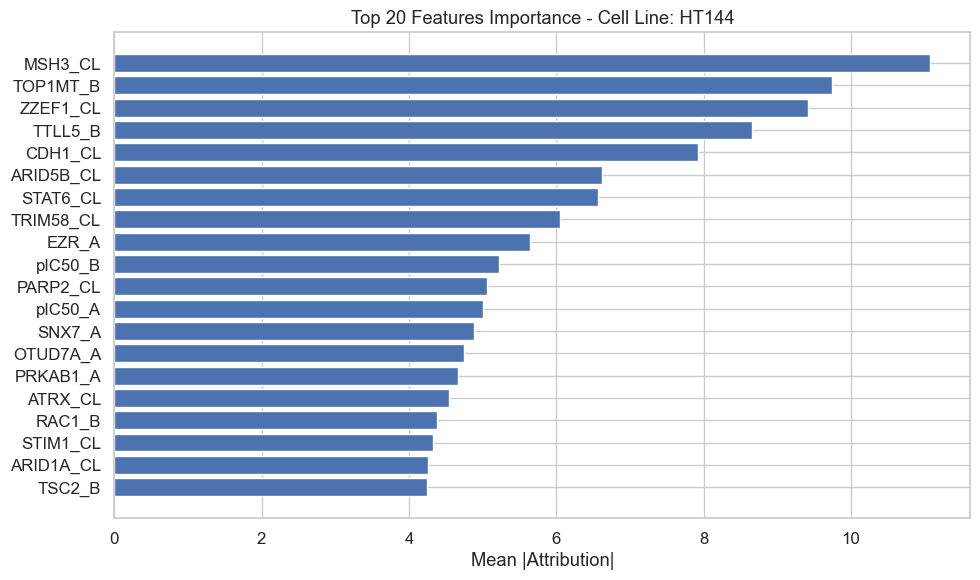

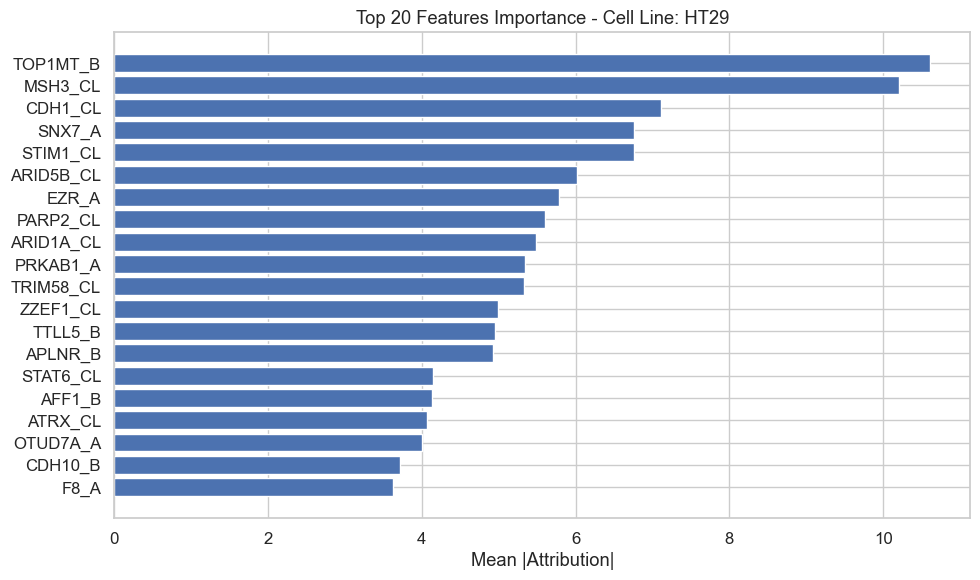

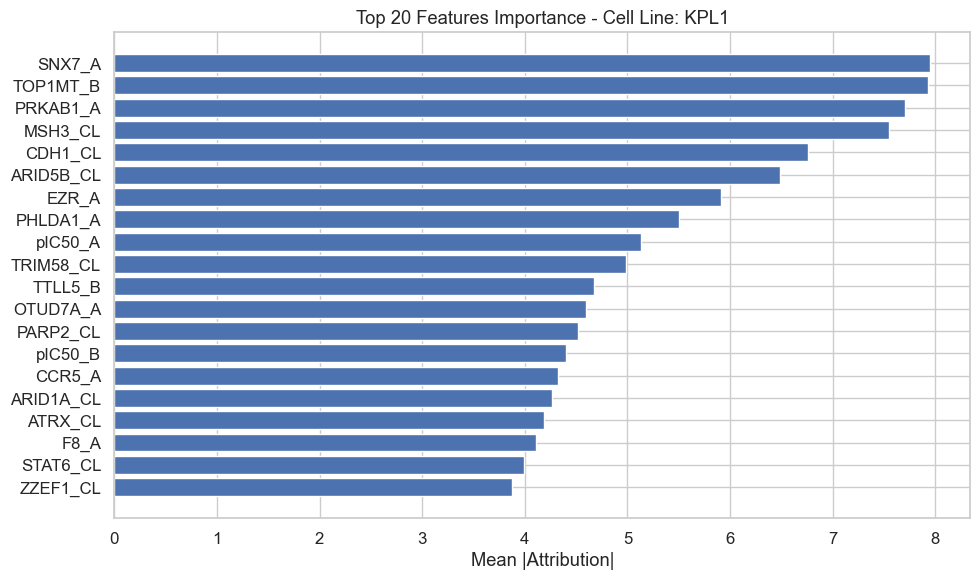

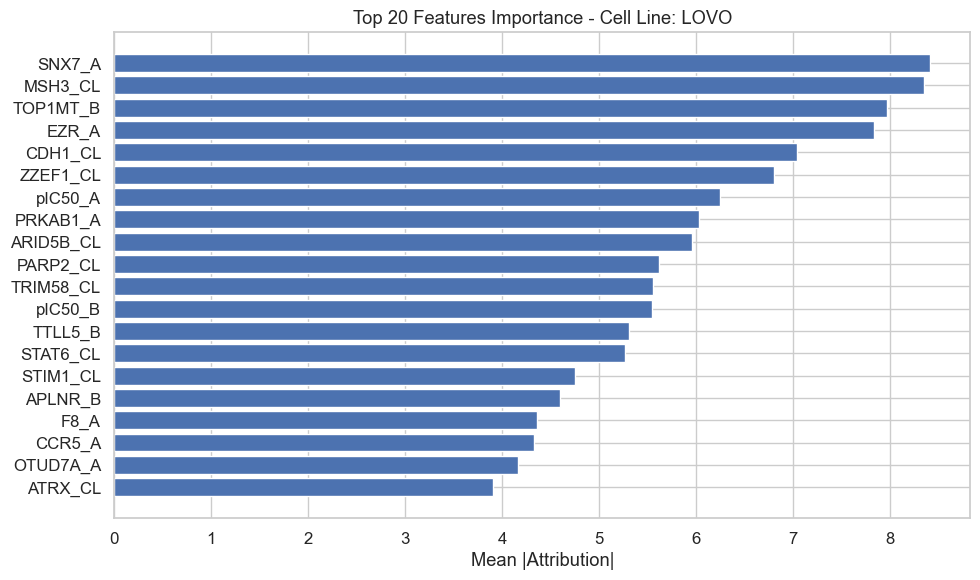

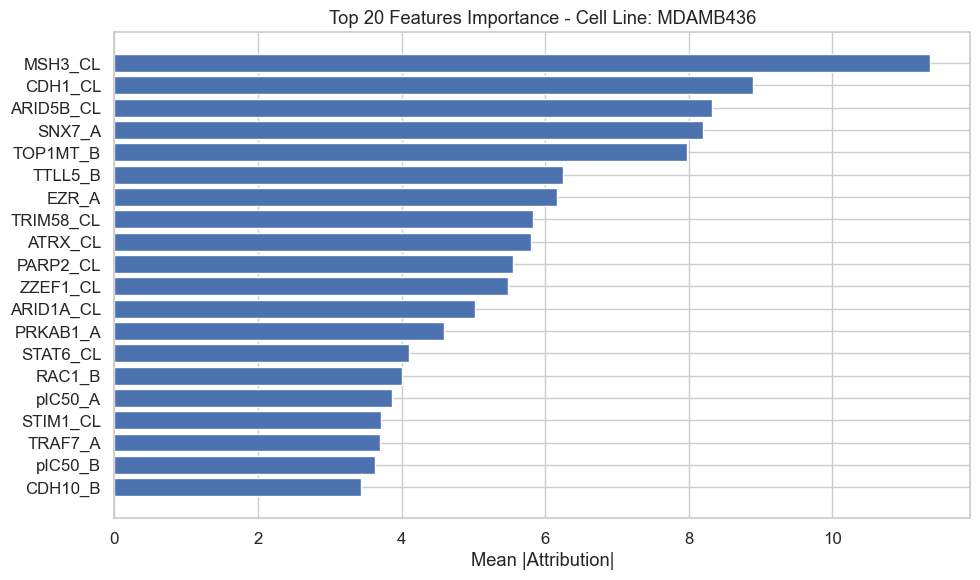

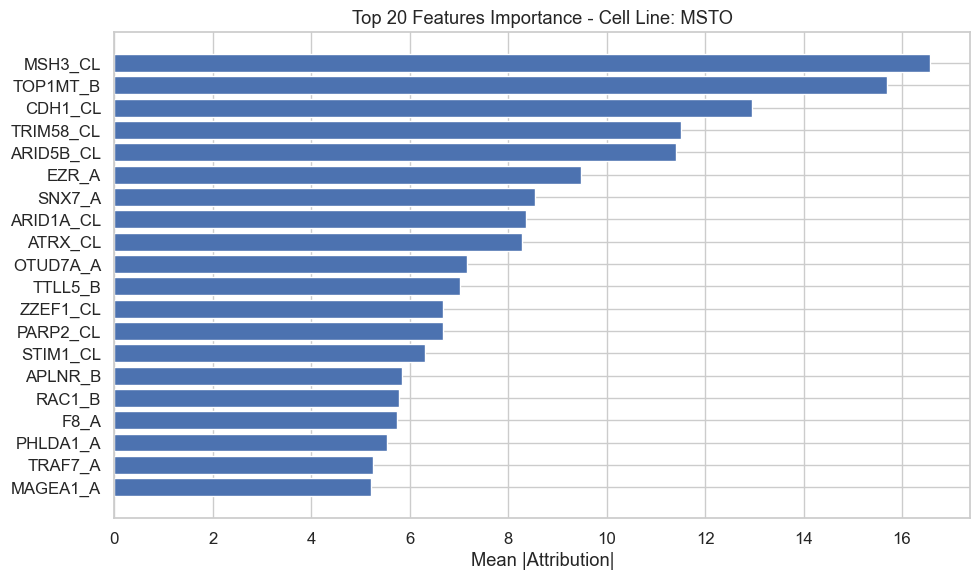

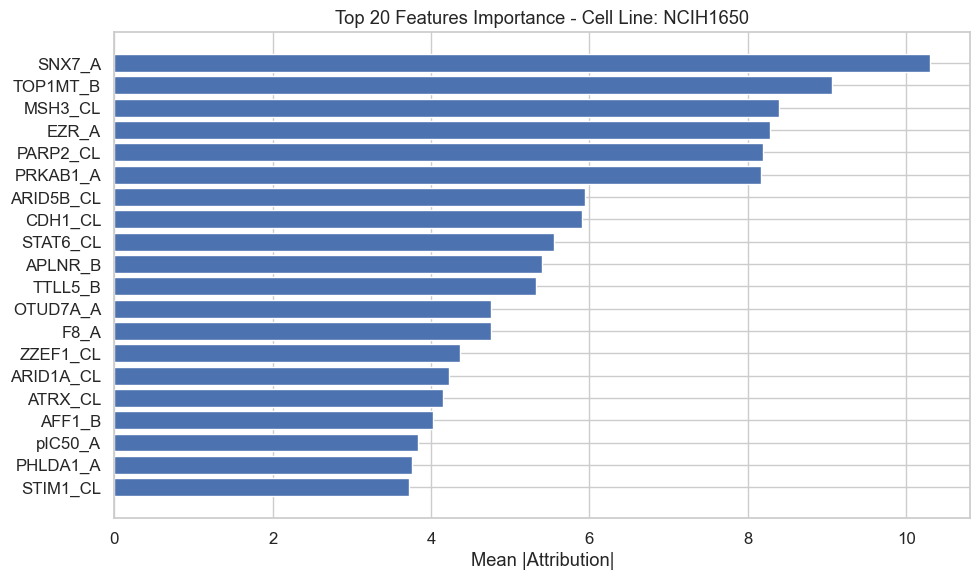

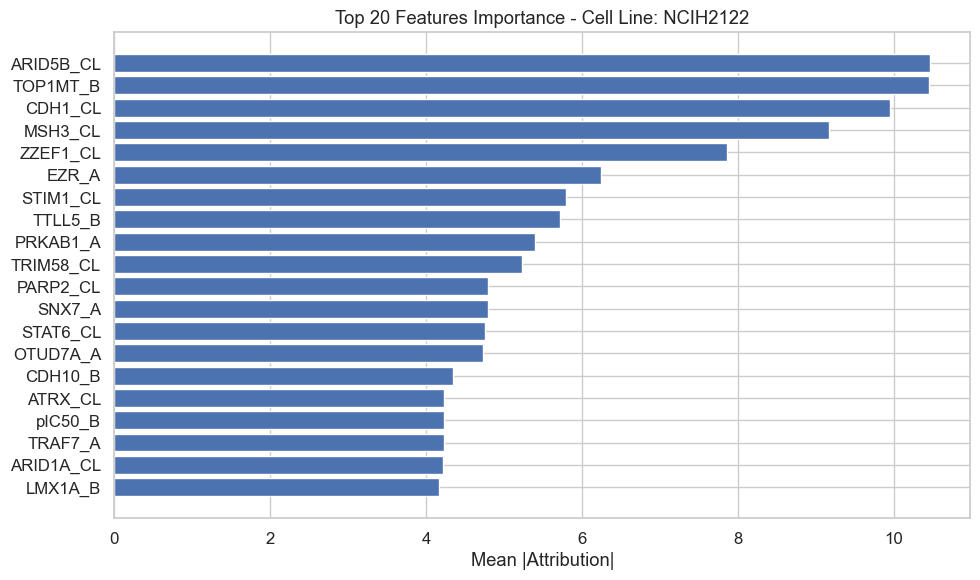

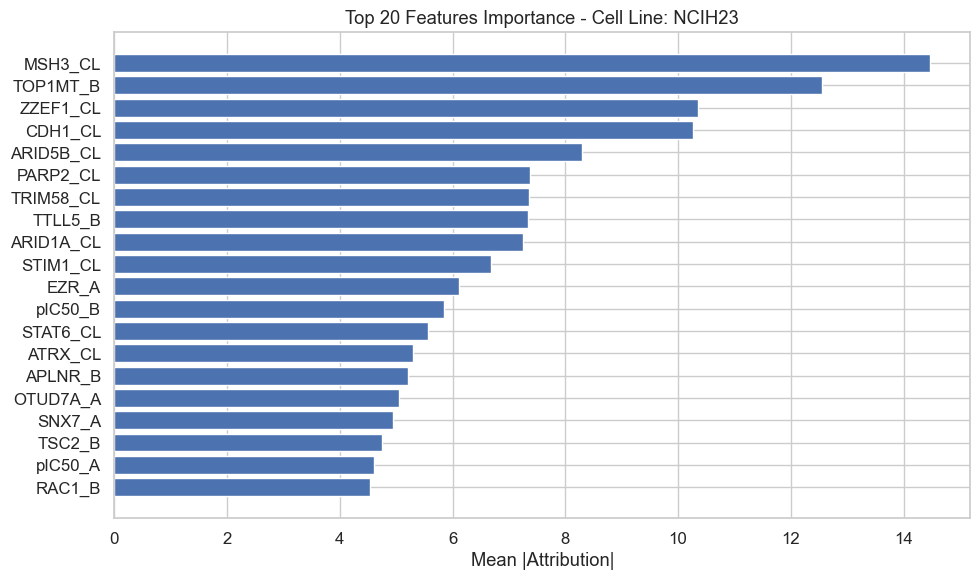

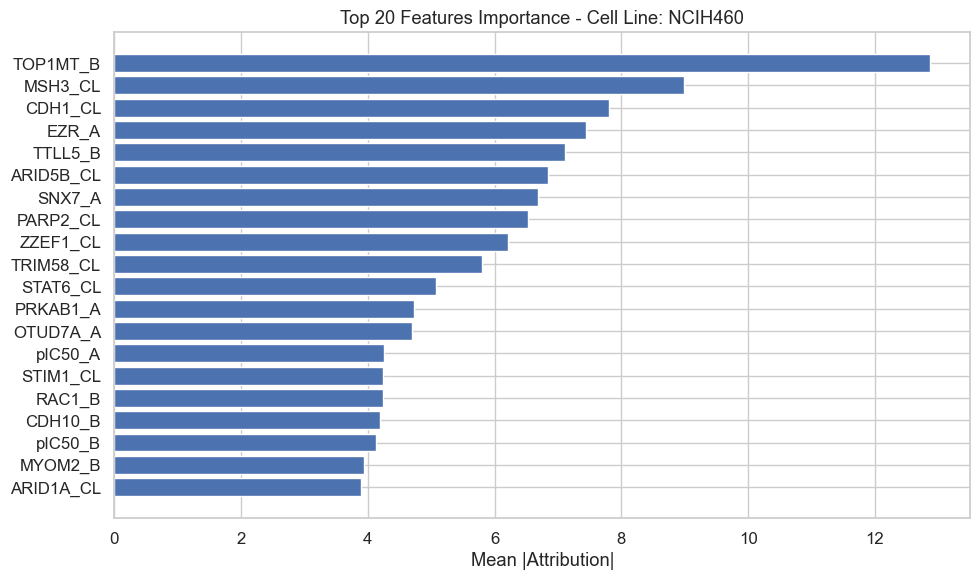

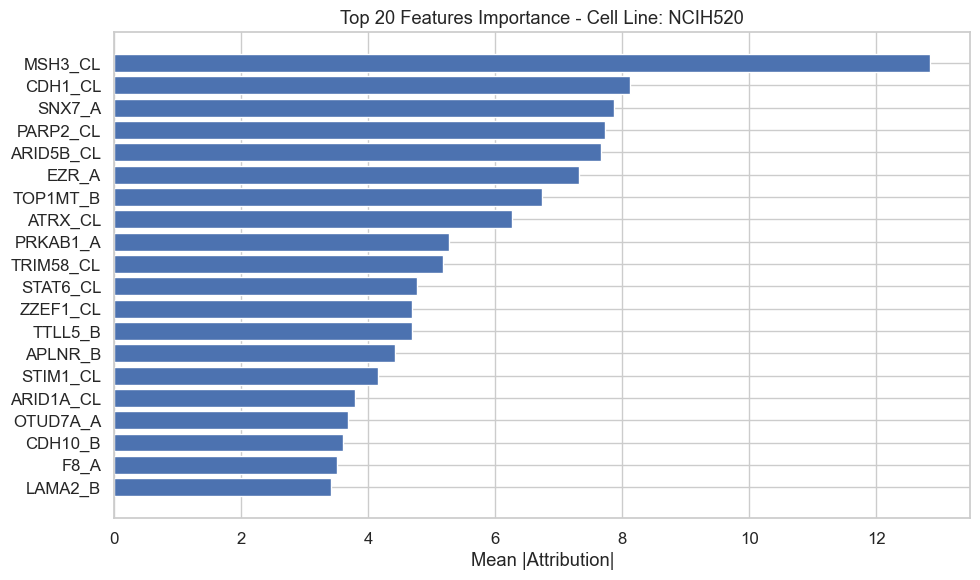

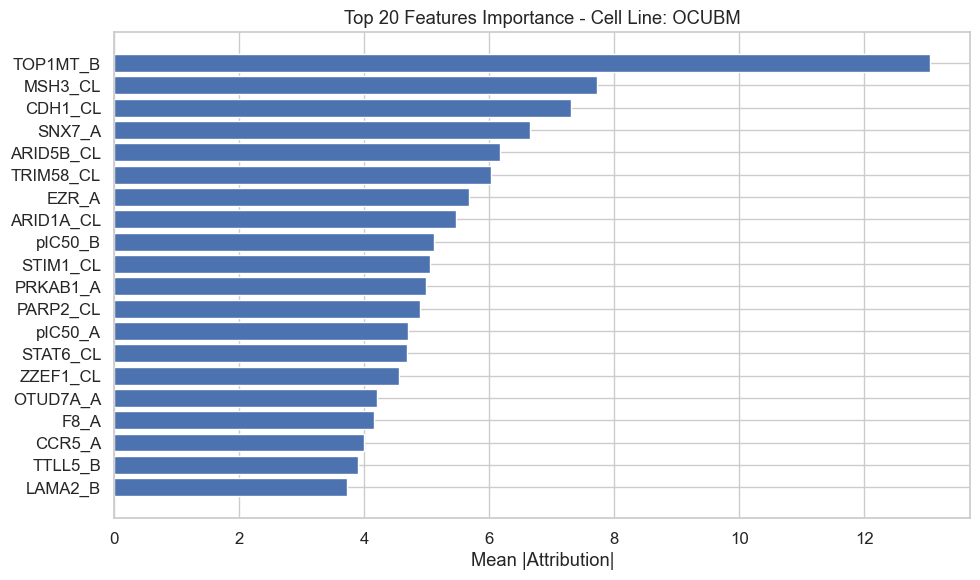

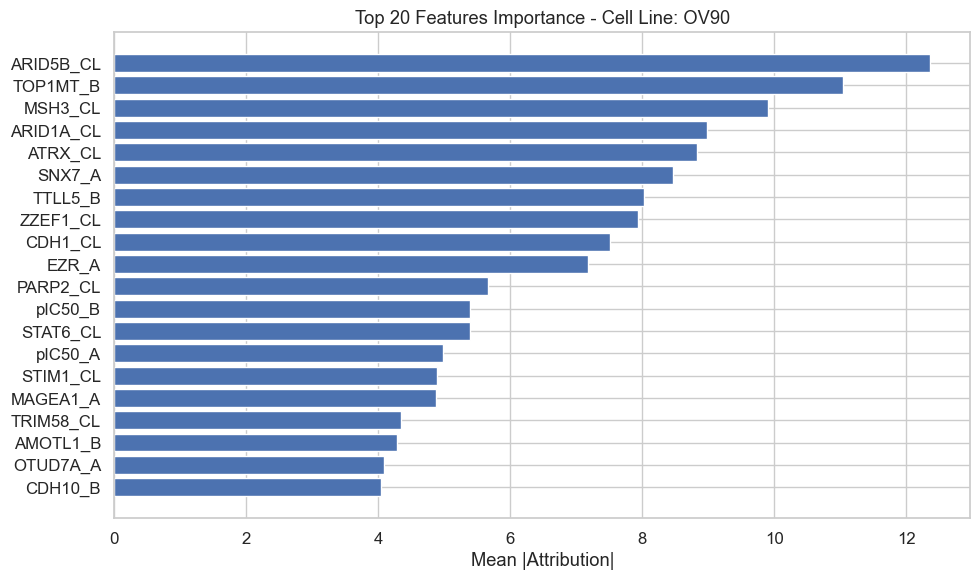

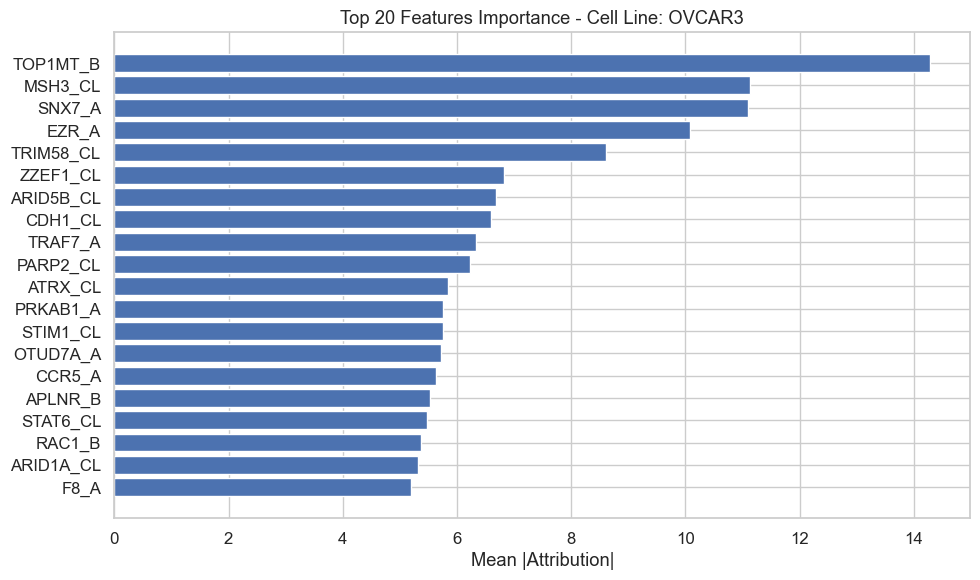

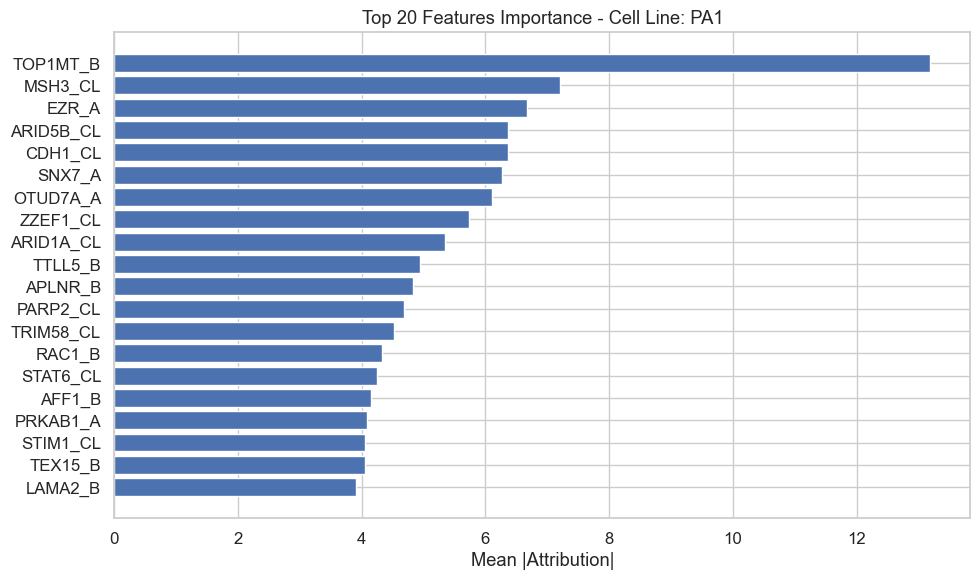

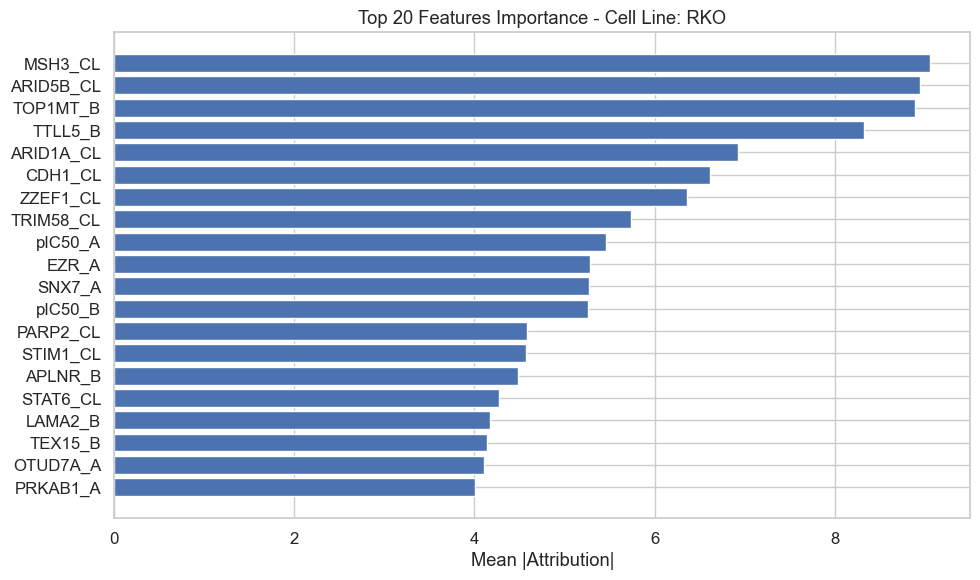

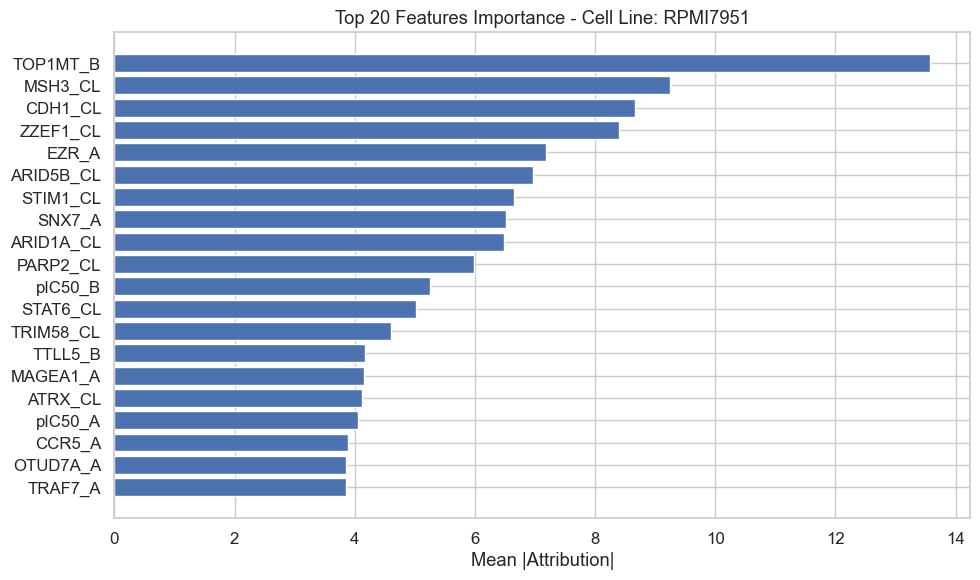

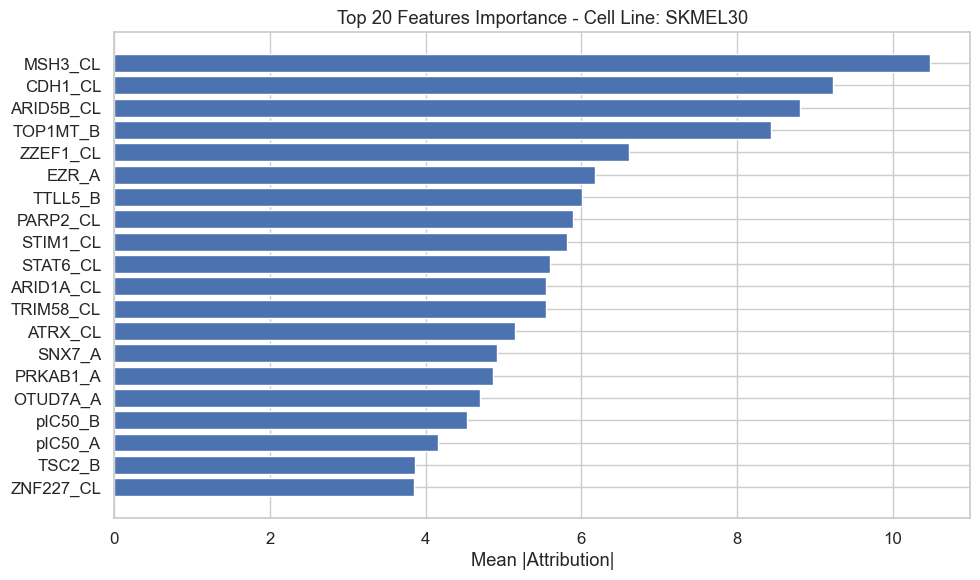

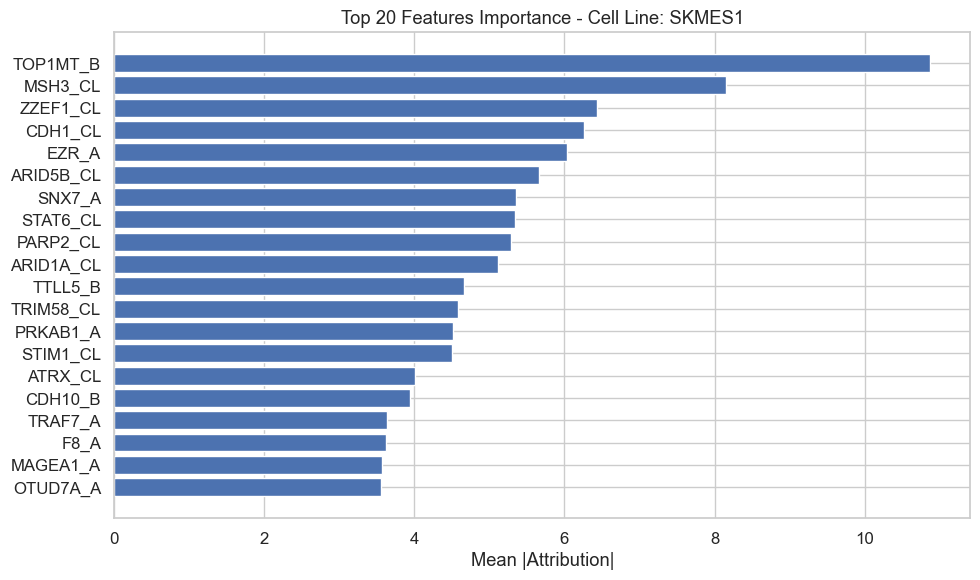

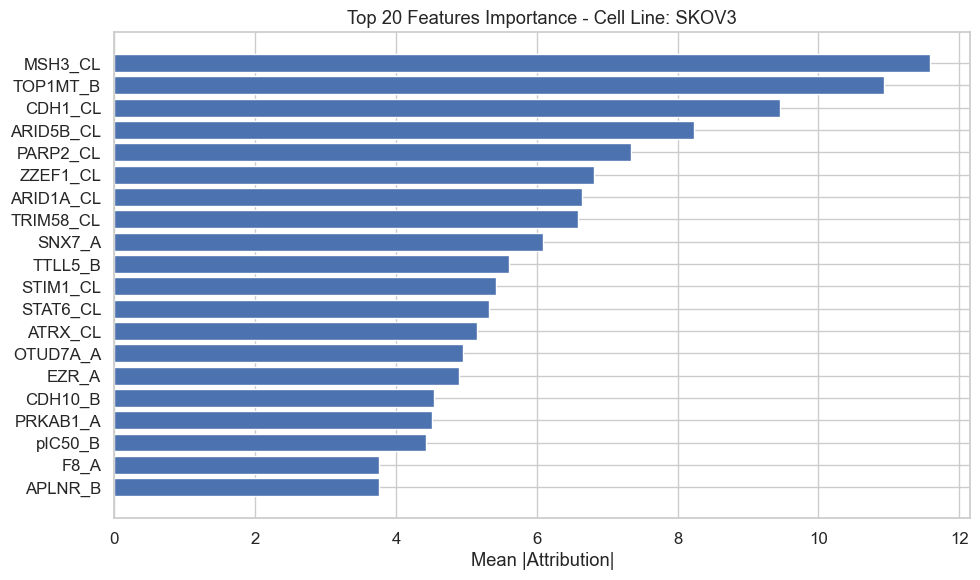

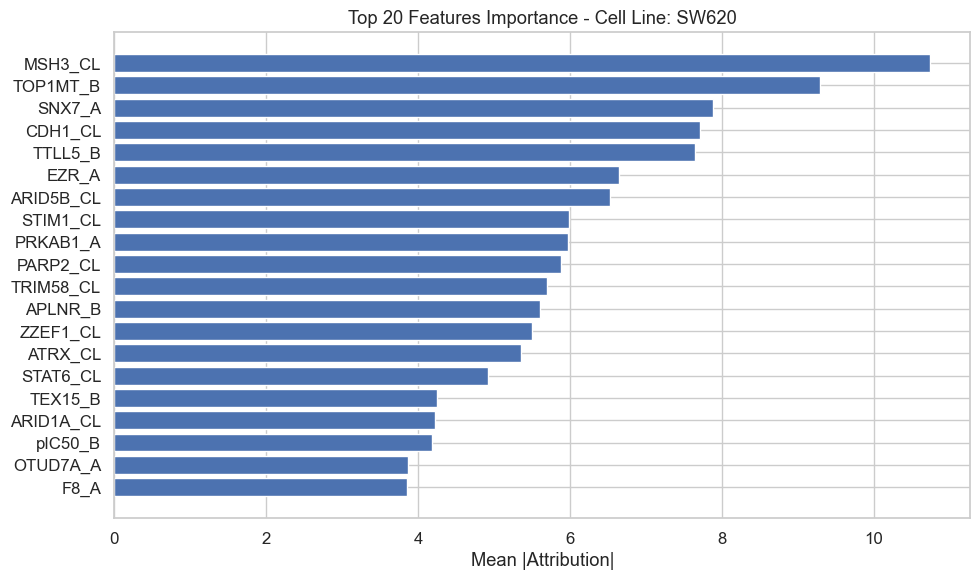

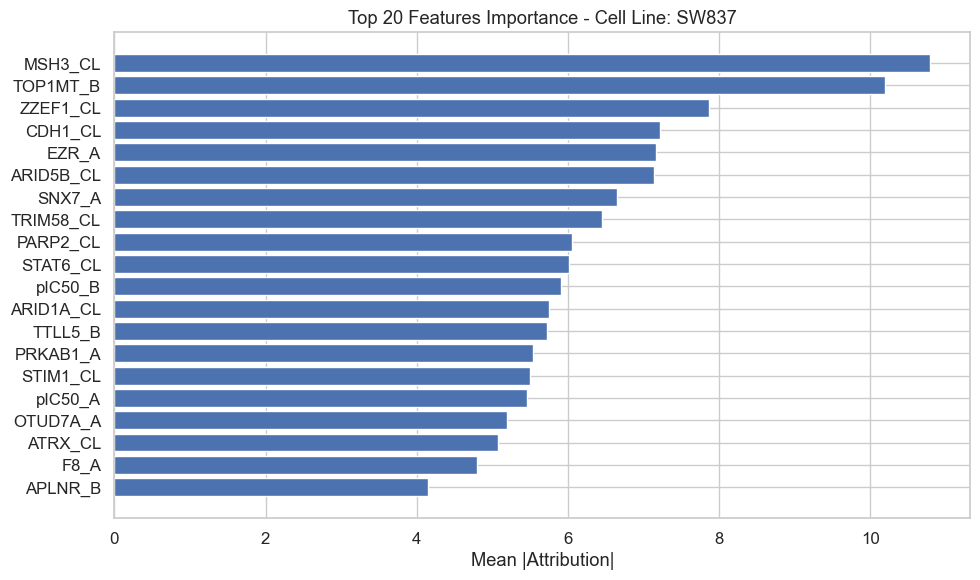

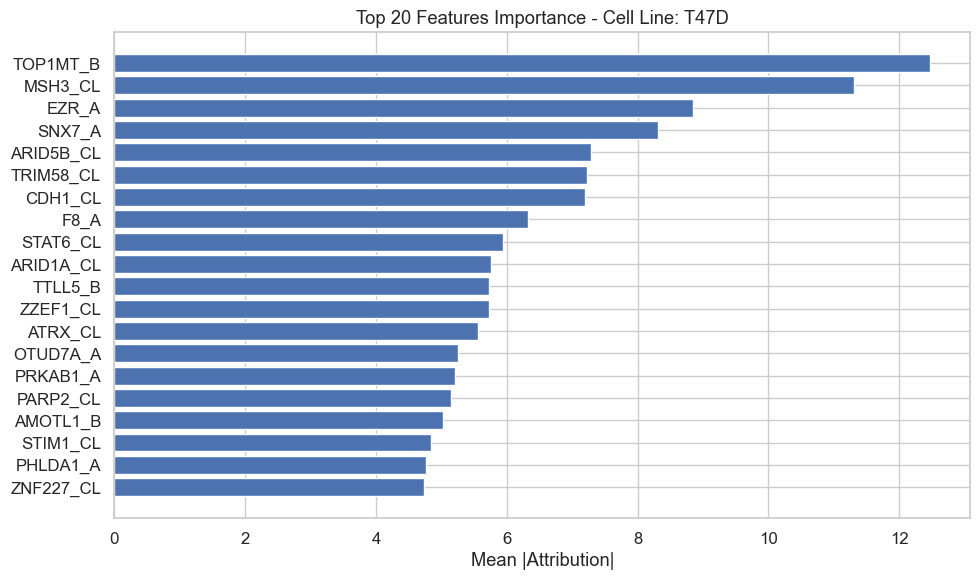

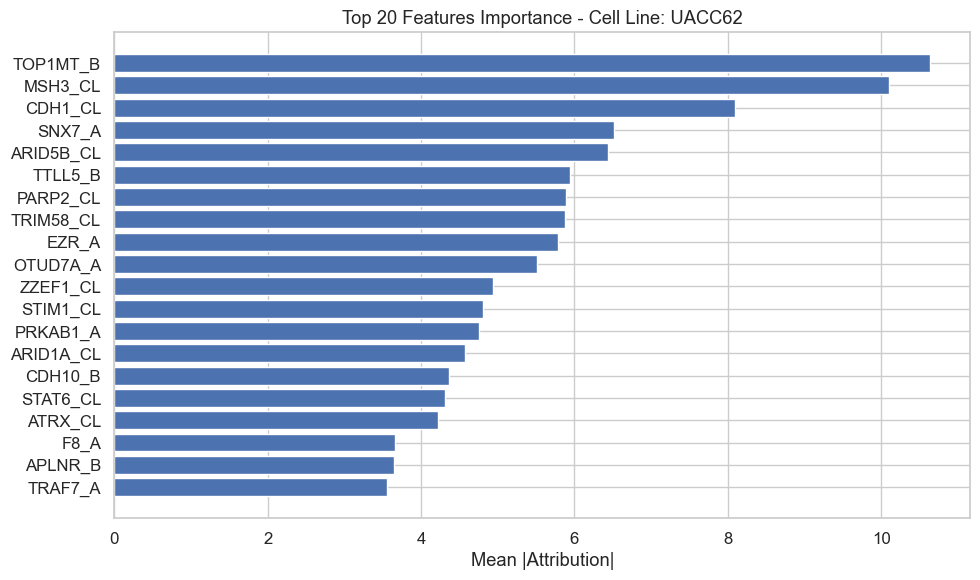

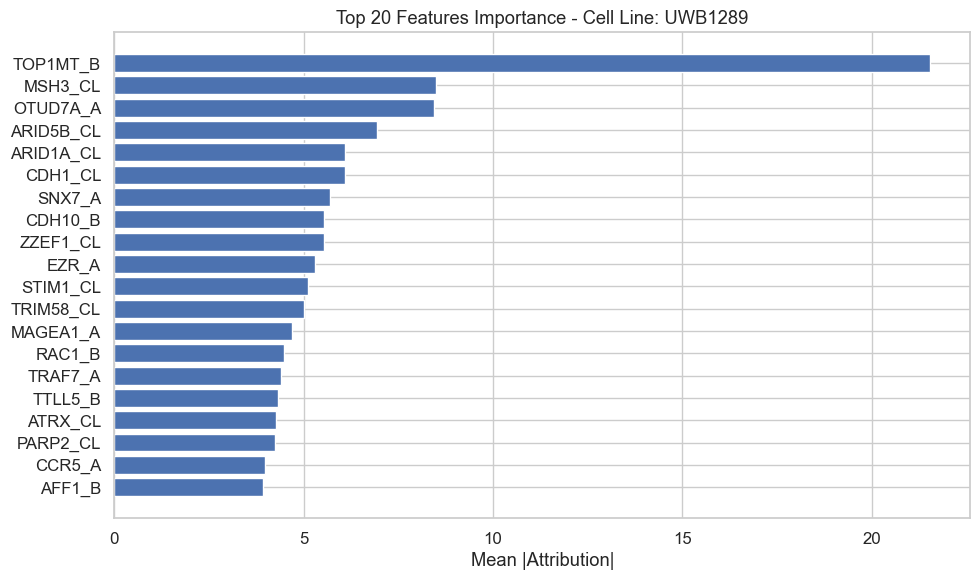

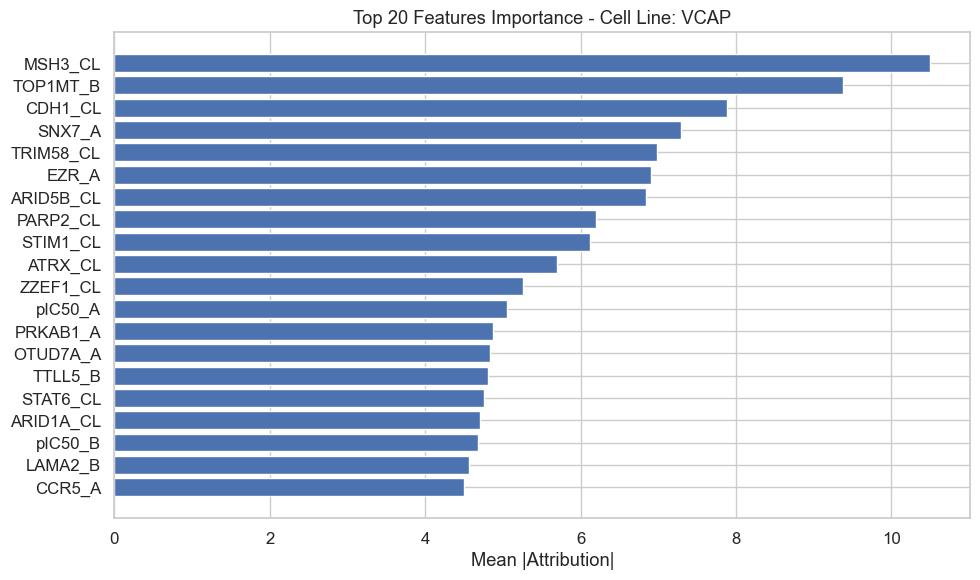

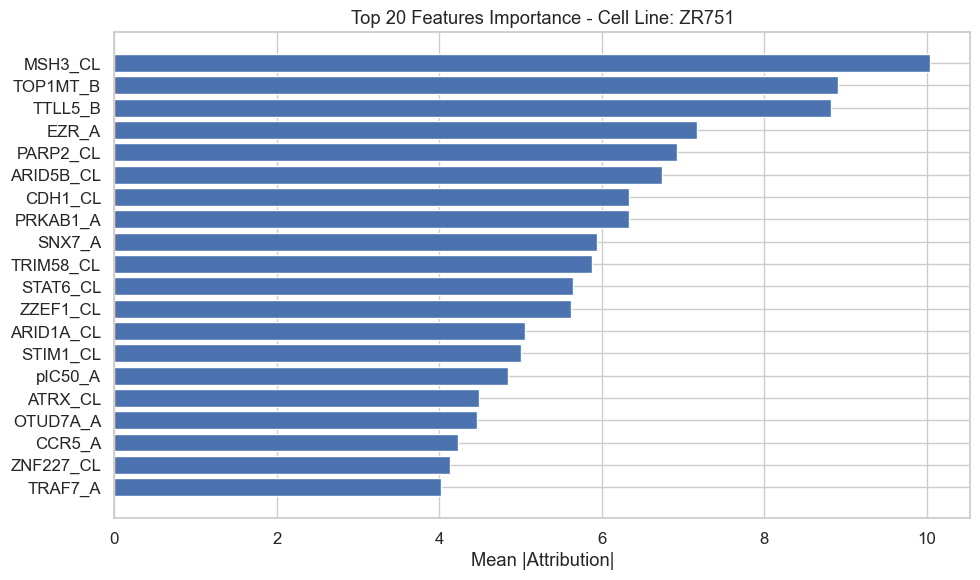

In [19]:
from explainability.data_utils import load_transynergy_cell_line_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_feature_importance_by_cell_line(all_attributions, feature_names, top_n=20):
    cell_lines = load_transynergy_cell_line_data(split='train')
    #permutation
    #cell_lines = np.concatenate([cell_lines, cell_lines], axis=0)
    unique_cell_lines = np.unique(cell_lines)

    for cell_line in unique_cell_lines:
        cell_line_indices = np.where(cell_lines == cell_line)[0]
        cell_line_attributions = all_attributions[cell_line_indices]
        
        mean_abs_attributions = np.mean(np.abs(cell_line_attributions), axis=0)

        importance_df = pd.DataFrame({
            "feature": feature_names,
            "mean_abs_attribution": mean_abs_attributions
        }).sort_values(by="mean_abs_attribution", ascending=False).head(top_n)
        
        plt.figure(figsize=(10, 6))
        plt.barh(importance_df["feature"][::-1], importance_df["mean_abs_attribution"][::-1])
        plt.xlabel("Mean |Attribution|")
        plt.title(f"Top {top_n} Features Importance - Cell Line: {cell_line}")
        plt.tight_layout()
        plt.show()


# Reshape the channels into 1 and convert the attributions to a NumPy array for easier manipulation
N = all_attributions.shape[0]
attributions_reshaped = all_attributions.squeeze(1).reshape(N, -1)  
attributions_np = attributions_reshaped.numpy()

plot_feature_importance_by_cell_line(attributions_np, feature_name)


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


[fold] Leakage:
  • Test ↔ Train: 0
  • Val  ↔ Train: 0
  • Val  ↔ Test : 0
Original rows: 18552
Remaining rows after cleaning: 18552


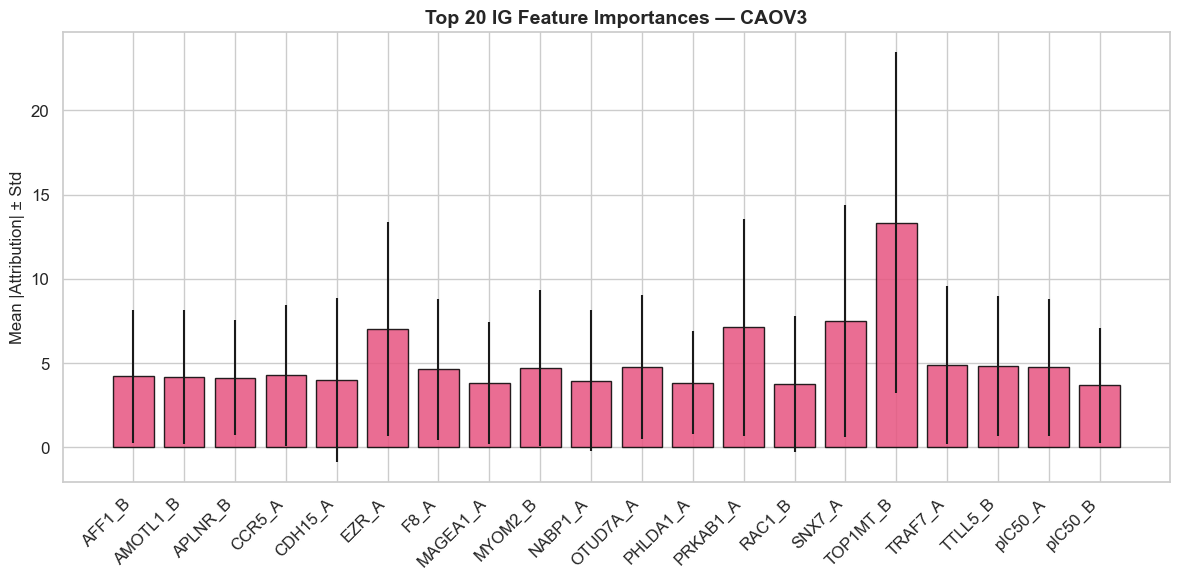

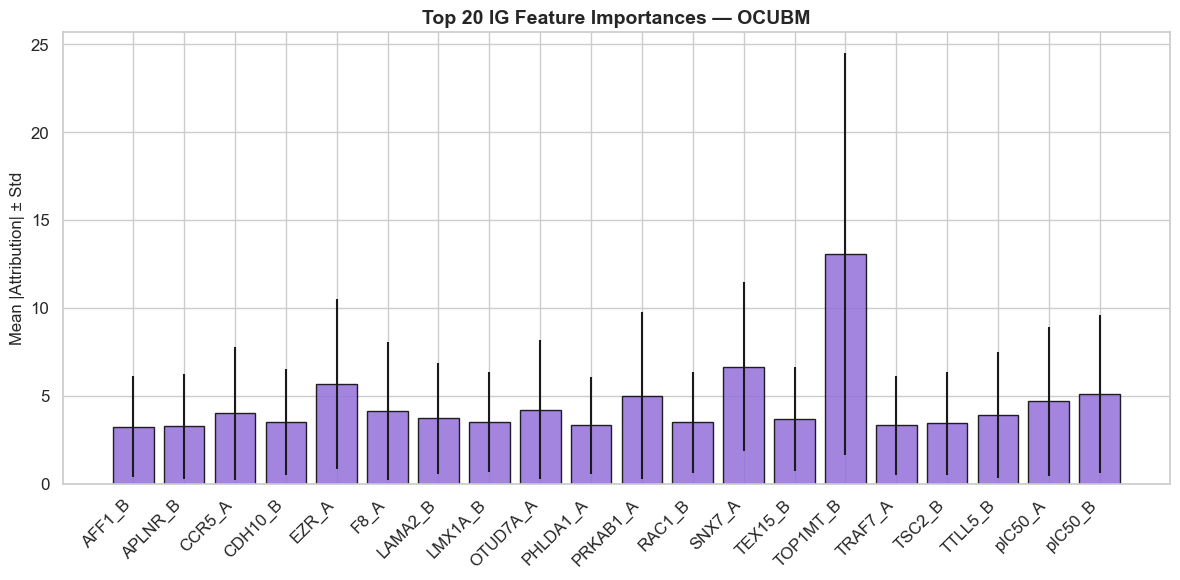

In [11]:
from explainability.data_utils import load_transynergy_cell_line_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_transynergy_ig_by_cell_line(all_attributions, feature_names, top_n=20):
    sns.set(style="whitegrid", font_scale=1.1)

    cell_lines = load_transynergy_cell_line_data(split='train')
    
    target_cell_lines = sorted(["CAOV3", "OCUBM"])
    color_map = {
        "CAOV3": "#e75480",  # pink
        "OCUBM": "#9370DB"   # purple
    }
    
    mask = np.isin(cell_lines, target_cell_lines)
    filtered_attributions = all_attributions[mask]
    filtered_cell_lines = cell_lines[mask]
    
   
    trimmed_features = feature_names[:-2402]
    filtered_attributions = filtered_attributions[:, :-2402]
    
    for cell_line in target_cell_lines:
        indices = np.where(filtered_cell_lines == cell_line)[0]
        attr_subset = filtered_attributions[indices]
        
        mean_abs_attr = np.mean(np.abs(attr_subset), axis=0)
        std_abs_attr = np.std(np.abs(attr_subset), axis=0)
        
        top_indices = np.argsort(mean_abs_attr)[-top_n:]
        top_features = np.array(trimmed_features)[top_indices]
        top_means = mean_abs_attr[top_indices]
        top_stds = std_abs_attr[top_indices]
        
        sorted_order = np.argsort(top_features)
        top_features = top_features[sorted_order]
        top_means = top_means[sorted_order]
        top_stds = top_stds[sorted_order]
        
        plt.figure(figsize=(12, 6))
        plt.bar(top_features, top_means, yerr=top_stds,
                color=color_map[cell_line], edgecolor='black', alpha=0.85)
        plt.ylabel("Mean |Attribution| ± Std", fontsize=12)
        plt.title(f"Top {top_n} IG Feature Importances — {cell_line}", fontsize=14, weight='bold')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

N = all_attributions.shape[0]
attributions_reshaped = all_attributions.squeeze(1).reshape(N, -1)
attributions_np = attributions_reshaped.numpy()
plot_transynergy_ig_by_cell_line(attributions_np, feature_name)


Interesting to note that both drug a and b features never present! This may be due to the reason explained before

# CAOV3
- ovarian cancer cell line 
- TOP1MT_B - Highest Attribution: is crucial for DNA replication and repair, ovarian cancer cells often have altered DNA repair mechanisms and mitochondrial dysfunction.
- PRKAB1_A - Second Highest: involved in regulating energy metabolism, which is crucial for cancer cell survival, particularly under stressful conditions
- EZR_A - Third highest: has a role in controlling cell shape, adhesion, migration and metastasis, all critical for cancer progression
- MAGEA1_A - Lowest: involved in immune evasion, antigenicity, not strong in this cell line type
- RAC1 - involved in cell migration, increase, and survival, it is surprising to be so low (to keep in mind it is still in the top 20), maybe others more important for this cell line

## OCUMB Cell Line:
- breast cancer cell line, models triple‑negative metastatic breast cancer (TNBC), a subtype with limited targeted treatment options, serves in studies of metastasis, tumor aggressiveness, and drug sensitivity
- TOP1MT_B - Highest Attribution: is crucial for DNA replication and repair, targeting mitochondrial DNA replication and repair mechanisms is a universal strategy
- SNX7 - Second highest: plays a role in intracellular trafficking and receptor regulation
- EZR_A - Third highest: has a role in controlling cell shape, adhesion, migration and metastasis, all critical for cancer progression
- TRAF7_A - Lowest importance: is involved in signal transduction and immune responses, for this particular cell line, immune-related signaling pathways may not be as critical